In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("zadorlab/neural-tangent-ensemble")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

summary_df = pd.json_normalize(summary_list)

# Flatten the 'config' column
config_df = pd.json_normalize(config_list)

# Concatenate the flattened DataFrames along with the 'name' column
runs_df = pd.concat([summary_df, config_df], axis=1)
runs_df.head()

,_runtime,_timestamp,num_params,step,epoch,_step,_wandb.runtime,train metrics.accuracy_3,train metrics.loss_0,train metrics.loss_4,...,update_freq_steps,optimizer.b1,optimizer.b2,optimizer.eps,optimizer.noise_scale,optimizer.log_Z,optimizer.reg_method,ntk_use_current_grads,optimizer.epsilon,model.features
0,951.379832,1.715831e+09,1796010.0,59999.0,9.0,10.0,950.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,973.372682,1.715830e+09,1796010.0,59999.0,9.0,10.0,963.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,971.519334,1.715829e+09,1796010.0,59999.0,9.0,10.0,971.0,NaN,NaN,2.335434,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,960.471252,1.715828e+09,1796010.0,59999.0,9.0,10.0,959.0,NaN,NaN,0.720967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,966.612402,1.715827e+09,1796010.0,59999.0,9.0,10.0,961.0,NaN,NaN,0.033465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
runs_df['logger.tags'].value_counts()

logger.tags
ablation           81
taylor_reset       57
bs_exp             44
eta_exp            28
log_Z              23
bs_exp_steps       22
alpha_exp          15
momentum_sweep     13
eta_exp_softmax    10
None                9
adaptive_temp       9
equal_init_exp      6
sgd_demo            5
[ntk]               2
init_params         2
init_grads          1
adam                1
[backprop]          1
Name: count, dtype: int64

In [22]:
# add number of parameters
runs_df['num_params'] = runs_df['model.features_per_layer'] * 785 + \
                        runs_df['model.features_per_layer'] * (runs_df['model.features_per_layer'] + 1) * (runs_df['model.nlayers'] - 1)\
                      + runs_df['model.nclasses'] * (runs_df['model.features_per_layer'] + 1)

# add a forgetting column
runs_df['First task accuracy after 5 tasks'] = runs_df['test metrics.accuracy_0'] * 100
runs_df['First task peak accuracy'] = runs_df['single_task.accuracy_0'] * 100
runs_df['Forgetting'] = 100*(runs_df['test metrics.accuracy_0'] - runs_df['single_task.accuracy_0'])
runs_df['Forgetting loss'] = (runs_df['test metrics.loss_0'] - runs_df['single_task.loss_0'])

Resetting the seed point of the Taylor expansion every now and then:

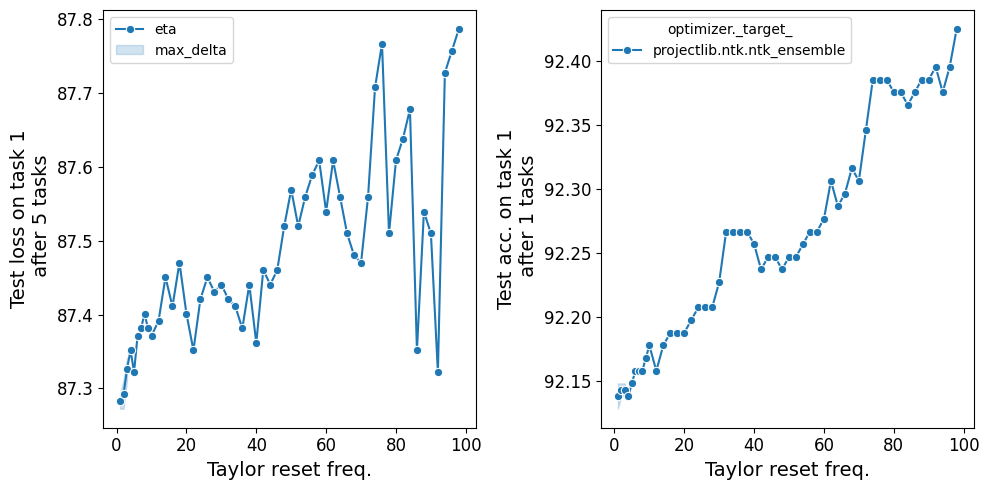

In [4]:
filter_ = runs_df['logger.tags'].isin(['taylor_reset'])
f,axs=plt.subplots(1,2,figsize=(10,5))
g=sns.lineplot(data=runs_df[filter_], x='optimizer.reset_taylor_steps',y='First task accuracy after 5 tasks', markers=True, style='optimizer._target_',ax=axs[0])
axs[0].legend(['eta','max_delta'
])
# axs[0].set_xscale('log')
axs[0].set_xlabel('Taylor reset freq.')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')

g=sns.lineplot(data=runs_df[filter_], x='optimizer.reset_taylor_steps',y='First task peak accuracy', markers=True, style='optimizer._target_', ax=axs[1])
# axs[1].set_xscale('log')
# axs[1].set_ylim(90,100)
axs[1].set_xlabel('Taylor reset freq.')
axs[1].set_ylabel('Test acc. on task 1\n after 1 tasks')
plt.tight_layout()


See the effect of $\alpha$, which affects the transition to lazy regime learning.

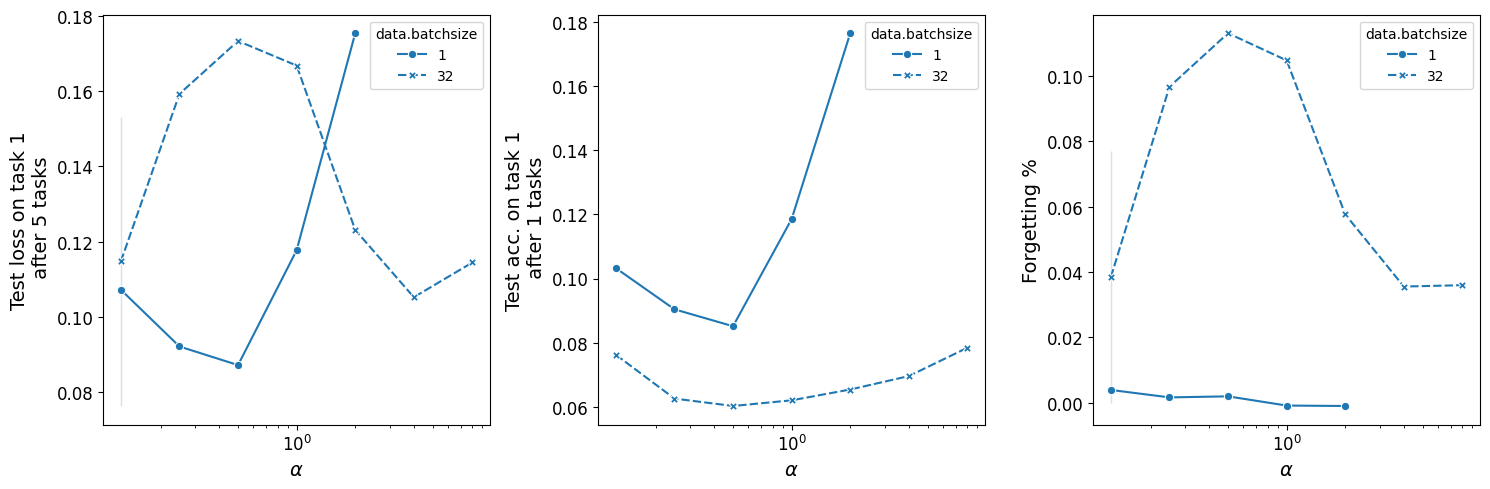

In [23]:
filter_ = runs_df['logger.tags'].isin(['alpha_exp2'])
f,axs=plt.subplots(1,3,figsize=(15,5))
g=sns.lineplot(data=runs_df[filter_], x='model.alpha',y='test metrics.loss_0', markers=True, style='data.batchsize',ax=axs[0])
axs[0].set_xscale('log')
# axs[0].set_ylim(90,100)
axs[0].set_xlabel(r'$\alpha$')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')

g=sns.lineplot(data=runs_df[filter_], x='model.alpha',y='single_task.loss_0', markers=True, style='data.batchsize', ax=axs[1])
axs[1].set_xscale('log')
# axs[1].set_ylim(90,100)
axs[1].set_xlabel(r'$\alpha$')
axs[1].set_ylabel('Test acc. on task 1\n after 1 tasks')


g=sns.lineplot(data=runs_df[filter_],  x='model.alpha',y='Forgetting loss', markers=True, style='data.batchsize', ax=axs[2])
axs[2].set_xscale('log')
axs[2].set_xlabel(r'$\alpha$')
axs[2].set_ylabel('Forgetting %')

plt.tight_layout()


The batch size does't matter so much when using vmap. This is good: we're doing proper SGD, but applying many updates per step.

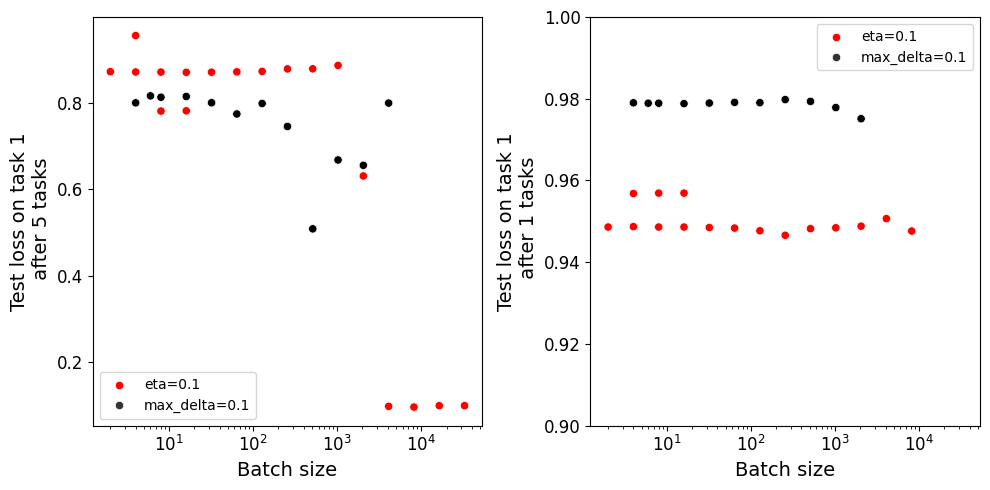

In [6]:

filter_1 = runs_df['logger.tags'].isin(['bs_exp']) & (runs_df['optimizer._target_']!='optax.sgd') & (runs_df['optimizer.eta']==0.1) 
filter_2 = runs_df['logger.tags'].isin(['bs_exp']) & (runs_df['optimizer._target_']!='optax.sgd') & (runs_df['optimizer.max_delta']==0.1)

f,axs=plt.subplots(1,2,figsize=(10,5))
g=sns.scatterplot(data=runs_df[filter_1], x='data.batchsize',y='test metrics.accuracy_0',style='optimizer.eta', markers=True,c='r', ax=axs[0])
g=sns.scatterplot(data=runs_df[filter_2], x='data.batchsize',y='test metrics.accuracy_0',style='optimizer.max_delta', markers=True,c='k', ax=axs[0])
axs[0].legend(['eta=0.1','max_delta=0.1'
])
axs[0].set_xscale('log')
axs[0].set_xlabel('Batch size')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')

g=sns.scatterplot(data=runs_df[filter_1], x='data.batchsize',y='single_task.accuracy_0',style='optimizer.eta', markers=True, c='r', ax=axs[1])
g=sns.scatterplot(data=runs_df[filter_2], x='data.batchsize',y='single_task.accuracy_0',style='optimizer.max_delta', markers=True, c='k', ax=axs[1])
axs[1].legend(['eta=0.1','max_delta=0.1'
])
axs[1].set_xscale('log')
axs[1].set_ylim(.9,1)
axs[1].set_xlabel('Batch size')
axs[1].set_ylabel('Test loss on task 1\n after 1 tasks')
plt.tight_layout()


For SGD with a set number of epochs, varying batchsize.

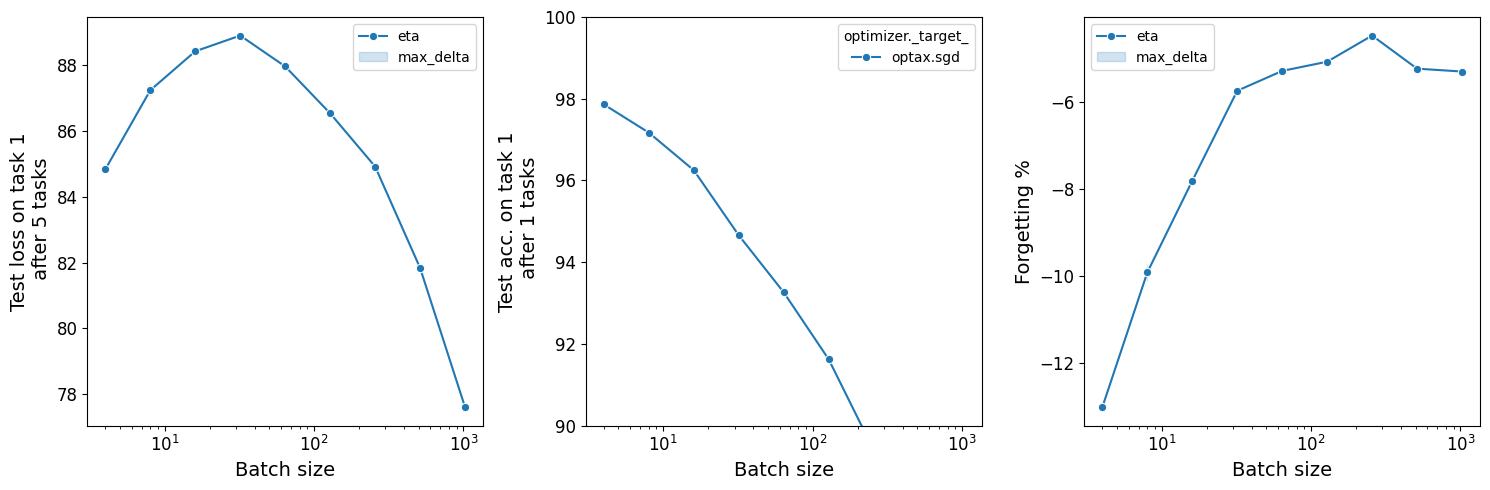

In [7]:

filter_ = runs_df['logger.tags'].isin(['bs_exp']) & (runs_df['optimizer._target_']=='optax.sgd')

f,axs=plt.subplots(1,3,figsize=(15,5))
g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='First task accuracy after 5 tasks', markers=True, style='optimizer._target_',ax=axs[0])
axs[0].legend(['eta','max_delta'
])
axs[0].set_xscale('log')
axs[0].set_xlabel('Batch size')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')

g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='First task peak accuracy', markers=True, style='optimizer._target_', ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_ylim(90,100)
axs[1].set_xlabel('Batch size')
axs[1].set_ylabel('Test acc. on task 1\n after 1 tasks')

g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='Forgetting', markers=True, style='optimizer._target_',ax=axs[2])
axs[2].legend(['eta','max_delta'
])
axs[2].set_xscale('log')
axs[2].set_xlabel('Batch size')
axs[2].set_ylabel('Forgetting %')

plt.tight_layout()
plt.show()
# runs_df[filter_][['num_params', 'model.features_per_layer', 'model.nlayers', 'optimizer.learning_rate', 'optimizer.momentum', 'test metrics.accuracy_0', 'data.batchsize']]

For a set number of steps, varying batchsize.

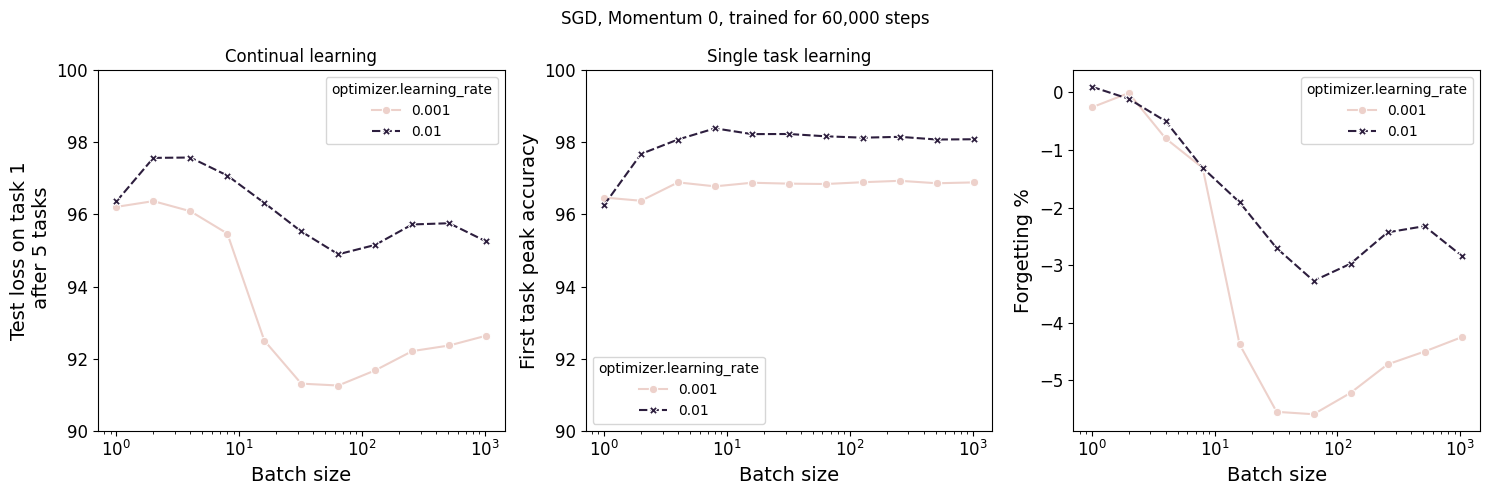

In [8]:

filter_ = runs_df['logger.tags'].isin(['bs_exp_steps']) & (runs_df['optimizer._target_']=='optax.sgd')

f,axs=plt.subplots(1,3,figsize=(15,5))
g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='First task accuracy after 5 tasks', markers=True, style='optimizer.learning_rate',ax=axs[0], hue='optimizer.learning_rate')
axs[0].set_xscale('log')
axs[0].set_xlabel('Batch size')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')
axs[0].set_title('Continual learning')
axs[0].set_ylim(90,100)

g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='First task peak accuracy', markers=True, style='optimizer.learning_rate', ax=axs[1], hue='optimizer.learning_rate')
axs[1].set_xscale('log')
axs[1].set_ylim(90,100)
axs[1].set_xlabel('Batch size')
# axs[1].set_ylabel('Test loss on task 1\n after 1 tasks')
axs[1].set_title('Single task learning')

g=sns.lineplot(data=runs_df[filter_], x='data.batchsize',y='Forgetting', markers=True, style='optimizer.learning_rate', ax=axs[2], hue='optimizer.learning_rate')
axs[2].set_xscale('log')
axs[2].set_xlabel('Batch size')
axs[2].set_ylabel('Forgetting %')


# axs[1].legend('')
plt.suptitle('SGD, Momentum 0, trained for 60,000 steps')
plt.tight_layout()
# plt.savefig('batch_size_sgd.svg')


# runs_df[filter_][['num_params', 'model.features_per_layer', 'model.nlayers', 'optimizer.learning_rate', 'optimizer.momentum', 'test metrics.accuracy_0', 'data.batchsize']]


Checking out ablations.

Text(35.87561728395062, 0.5, 'Test accuracy change on task 1\n after 5 tasks')

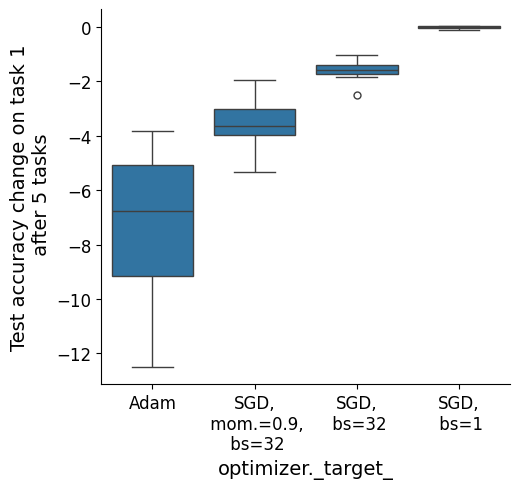

In [9]:
filter_ = runs_df['logger.tags'].isin(['ablation']) & (runs_df['training.nsteps']==60000)

df = runs_df[filter_]

df.loc[(runs_df['optimizer._target_']=='optax.sgd')
        & (runs_df['optimizer.momentum']>0)
        & (runs_df['data.batchsize']==32),'optimizer._target_'] = 'SGD,\n mom.=0.9,\n bs=32'
df.loc[(runs_df['optimizer._target_']=='optax.sgd') & ~(runs_df['optimizer.momentum']>0)
        & (runs_df['data.batchsize']==32),'optimizer._target_'] = 'SGD,\n bs=32'
df.loc[(runs_df['optimizer._target_']=='optax.sgd') & ~(runs_df['optimizer.momentum']>0)
        & (runs_df['data.batchsize']==1),'optimizer._target_'] = 'SGD,\n bs=1'
df.loc[(runs_df['optimizer._target_']=='optax.adam'),'optimizer._target_'] = 'Adam'

order = ['Adam','SGD,\n mom.=0.9,\n bs=32','SGD,\n bs=32','SGD,\n bs=1']
sns.catplot(data=df, x='optimizer._target_',y='Forgetting', kind='box', order=order)
plt.ylabel('Test accuracy change on task 1\n after 5 tasks')


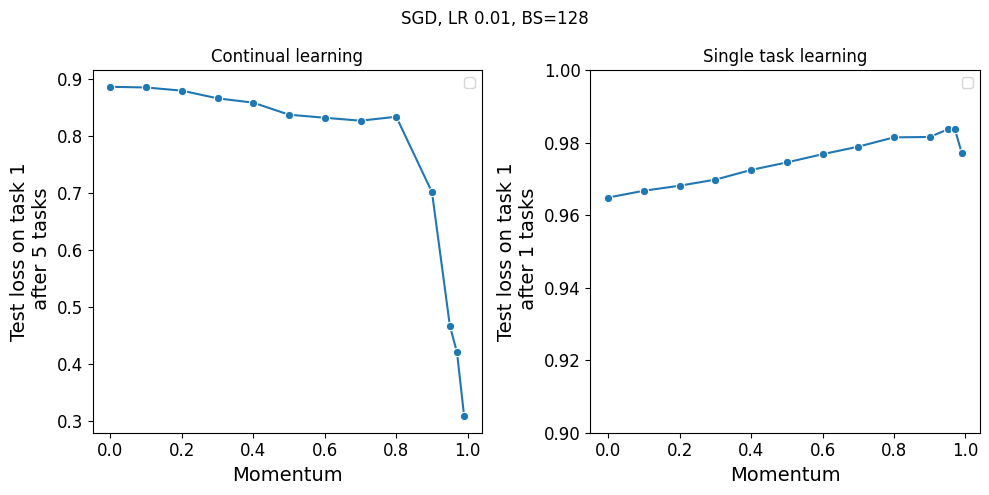

In [10]:
filter_ = runs_df['logger.tags'].isin(['momentum_sweep']) 
# df = runs_df[filter_]

# filter_ = runs_df['logger.tags'].isin(['bs_exp_steps']) & (runs_df['optimizer._target_']=='optax.sgd')

f,axs=plt.subplots(1,2,figsize=(10,5))
g=sns.lineplot(data=runs_df[filter_], x='optimizer.momentum',y='test metrics.accuracy_0', markers=True, style='optimizer._target_',ax=axs[0])
# axs[0].set_xscale('log')
axs[0].set_xlabel('Momentum')
axs[0].set_ylabel('Test loss on task 1\n after 5 tasks')
axs[0].set_title('Continual learning')
axs[0].legend('')

g=sns.lineplot(data=runs_df[filter_], x='optimizer.momentum',y='single_task.accuracy_0', markers=True, style='optimizer._target_', ax=axs[1])
# axs[1].set_xscale('log')
axs[1].set_ylim(.9,1)
axs[1].set_xlabel('Momentum')
axs[1].set_ylabel('Test loss on task 1\n after 1 tasks')
axs[1].set_title('Single task learning')
axs[1].legend('')
plt.suptitle('SGD, LR 0.01, BS=128')
plt.tight_layout()
# plt.savefig('batch_size_sgd.svg')


# runs_df[filter_][['num_params', 'model.features_per_layer', 'model.nlayers', 'optimizer.learning_rate', 'optimizer.momentum', 'test metrics.accuracy_0', 'data.batchsize']]


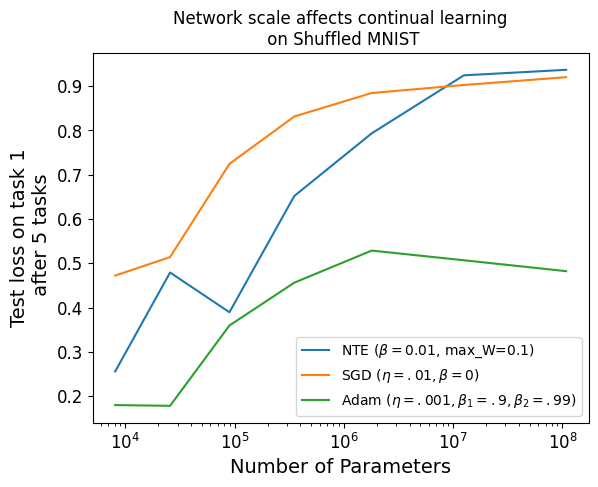

In [11]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  &  (runs_df['optimizer.momentum'] != 0.9) & runs_df['logger.tags'].isna() \
    # &(runs_df['optimizer._target_']!='projectlib.ntk.ntk_ensemble')

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.accuracy_0',hue='optimizer._target_', markers=True,)
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

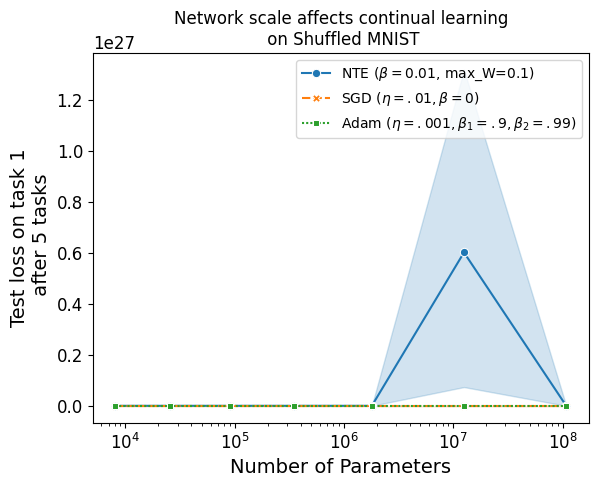

In [35]:

filter_ = np.isnan(runs_df['optimizer.epsilon']) & (runs_df['ntasks']==5)  & (runs_df['ntasks']==5)  * (runs_df['optimizer.momentum'] != 0.9)

g=sns.lineplot(data=runs_df[filter_], x='num_params',y='test metrics.loss_0',hue='optimizer._target_', markers=True, style='optimizer._target_')
plt.xscale('log')
plt.xlabel('Number of Parameters')
plt.ylabel('Test loss on task 1\n after 5 tasks')
plt.title("Network scale affects continual learning\n on Shuffled MNIST")
new_labels ={'sgd':r"SGD ($\eta=.01, \beta=0$)",
              'nte': r"NTE ($\beta=0.01$, max_W=0.1)", 
              'adam':r'Adam ($\eta=.001, \beta_1=.9, \beta_2=.99$)'}

g.legend()
for t in g.legend_.texts:
#     t.set_text(l)
    if 'sgd' in t.get_text():
        t.set_text(new_labels['sgd'])
    elif 'ens' in t.get_text():
        t.set_text(new_labels['nte'])
    elif 'adam' in t.get_text():
        t.set_text(new_labels['adam'])

## The adaptive temperature experiment failed

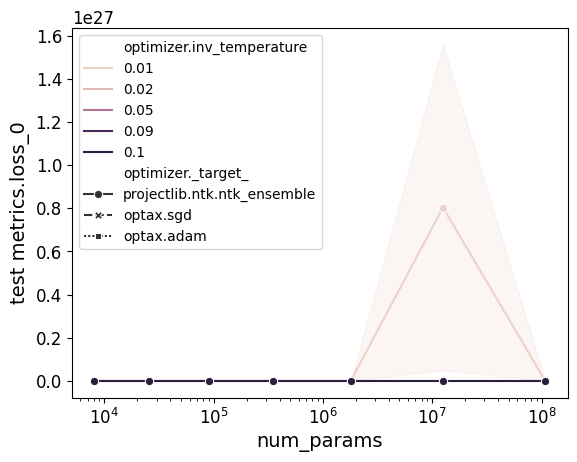

In [36]:
sns.lineplot(data=runs_df, x='num_params',y='test metrics.loss_0',hue='optimizer.inv_temperature', markers=True, style='optimizer._target_')
plt.xscale('log')
